In [1]:
# load modules (install floris)
from floris.floris import Floris
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import GPy
import random
# Visualization
from copy import deepcopy
from visualization_manager import VisualizationManager

from pareto import Pareto
from BayesianOpt import *
%matplotlib inline

In [2]:
def multi_func(X):
    X1 = X[:,0][:,None]; X2 = X[:,1][:,None]
    f1 = np.square(1-X2) + 100* np.square((X1+0.1)-np.square(X2))-1
    f2 = np.square(1-X2) + 100* np.square(X1-np.square(X2))-1
    Y = np.hstack((f1,f2))
    return Y

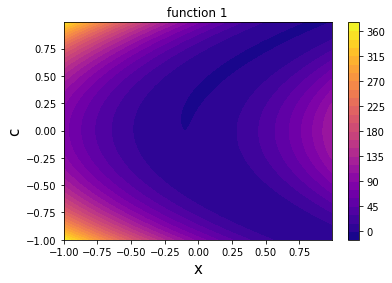

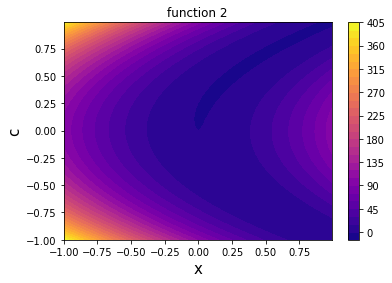

In [3]:
x_coord = np.arange(-1,1,0.01)
y_coord = np.arange(-1,1,0.01)
cont_X = np.linspace(-1,1,1001)
cont_Y = np.ones(len(cont_X)) * 0

x, y = np.meshgrid(x_coord, y_coord)
XX = np.hstack((x.ravel()[:,None], y.ravel()[:,None]))
f1 = multi_func(XX)[:,0].reshape(len(y_coord),len(x_coord))
f2 = multi_func(XX)[:,1].reshape(len(y_coord),len(x_coord))

cs = plt.contourf(x, y, f1, 30, cmap='plasma')
norm= matplotlib.colors.Normalize(vmin=cs.cvalues.min(), vmax=cs.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap = cs.cmap)
sm.set_array([])

plt.title('function 1')
plt.xlabel('x', fontsize = 15)
plt.ylabel('c', fontsize = 15)
# plt.plot(cont_X, cont_Y, color = 'red')
plt.colorbar()
plt.savefig('1-1.png')
plt.show()

plt.contourf(x, y, f2, 30, cmap='plasma')
plt.title('function 2')
plt.xlabel('x', fontsize = 15)
plt.ylabel('c', fontsize = 15)
# plt.plot(cont_X, cont_Y, color = 'red')
plt.colorbar()
plt.savefig('1-2.png')
plt.show()

## Input space plot

In [4]:
opt_x = []
opt_y = []
for c in np.linspace(-1,1,500):
    test_X1 = np.linspace(-1,1,500)
    test_X2 = np.ones(len(test_X1)) * c
    
    pareto = Pareto(np.empty((0,2)))
    f_value = multi_func(np.hstack((test_X1[:,None], test_X2[:,None])))
    pareto.update(f_value)
    
    idx = np.array([i for i in range(len(f_value)) if f_value[i,0] in pareto.front[:,0] and f_value[i,1] in pareto.front[:,1]])
    opt_x.extend(test_X1[idx])
    opt_y.extend(test_X2[idx])


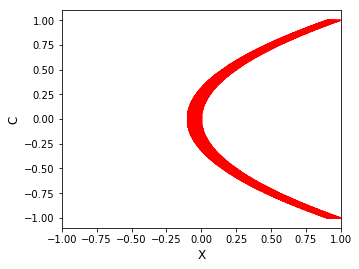

In [5]:
plt.figure(figsize=(5,4))
plt.xlim([-1,1])
# plt.scatter(opt_x, opt_y, s = 5, marker = 's', color = 'red')
plt.xlabel('X', fontsize = 12)
plt.ylabel('C', fontsize = 12)
plt.plot(opt_x, opt_y, color = 'red')
plt.show()

In [6]:
x_coord = np.arange(-1,1,0.01)
y_coord = np.arange(-1,1,0.01)

x, y = np.meshgrid(x_coord, y_coord)
XX = np.hstack((x.ravel()[:,None], y.ravel()[:,None]))
f1 = multi_func(XX)[:,0].reshape(len(y_coord),len(x_coord))
f2 = multi_func(XX)[:,1].reshape(len(y_coord),len(x_coord))

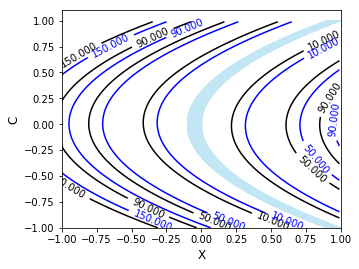

In [7]:
plt.figure(figsize=(5,4))
plt.xlim([-1,1])
plt.xlabel('X', fontsize = 12)
plt.ylabel('C', fontsize = 12)

cs1 = plt.contour(x, y, f1, levels = [10, 50, 90, 150], colors = 'black')
plt.clabel(cs1, cs1.levels, inline = 1, colors = 'black', fontsize=10 )
cs2 = plt.contour(x, y, f2, levels = [10, 50, 90, 150], colors = 'blue')
plt.clabel(cs2, cs2.levels, inline = 1, colors = 'blue', fontsize=10 )

plt.plot(opt_x, opt_y, color = 'skyblue', alpha = 0.5)
plt.show()

In [20]:
minimum = -1
maximum = 1

bounds = np.array([[minimum, maximum]])

# initial data point of wind-farm
init_sample = 5
c_init = np.random.uniform(-1, 1, init_sample)[:,None]
X = np.zeros((init_sample, bounds.shape[0]))
for i, actions in enumerate(np.random.uniform(bounds[:, 0], bounds[:, 1], (init_sample, bounds.shape[0]))):
    X[i,:] = actions
X = np.hstack((X, c_init))
Y = multi_func(X)

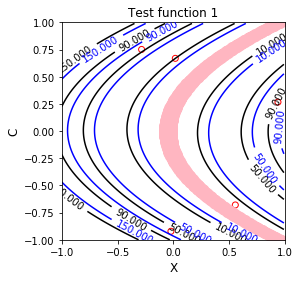

In [21]:
plt.figure(figsize=(4,4))
plt.xlim([-1,1])
plt.ylim([-1,1])

plt.title('Test function 1', fontsize = 12)
plt.xlabel('X', fontsize = 12)
plt.ylabel('C', fontsize = 12)

cs1 = plt.contour(x, y, f1, levels = [10, 50, 90, 150], colors = 'black')
plt.clabel(cs1, cs1.levels, inline = 1, colors = 'black', fontsize=10 )
cs2 = plt.contour(x, y, f2, levels = [10, 50, 90, 150], colors = 'blue')
plt.clabel(cs2, cs2.levels, inline = 1, colors = 'blue', fontsize=10 )

plt.scatter(X[:,0], X[:,1], facecolors='none', edgecolors='red')

plt.scatter(opt_x, opt_y, color = 'lightpink', alpha = 0.4, zorder=1)
plt.savefig('test_fun1_init.png', bbox_inches='tight')
plt.show()

In [22]:
num_output = Y.shape[1]
n_params = bounds.shape[0] + 1

num_iter = 200
c_context = np.random.uniform(-1, 1, size=(num_iter, 1))

for i in range(num_iter):
    pareto = Pareto(np.empty((0, num_output)))
    reference = np.ones((1, num_output))
    
    gp_models = [GPy.models.GPRegression(X.copy(), Y[:,[i]].copy(), kernel= GPy.kern.Matern52(input_dim=n_params, ARD=True)) for i in range(Y.shape[1])]
    for model in gp_models:
        model.optimize()
        
    context_X = np.hstack((X[:,:-1], np.ones((len(X), 1)) * c_context[i]))
    preds =  [m.predict(context_X) for m in gp_models]
    context_Y, var = (np.concatenate(moment, 1) for moment in zip(*preds))
    pareto.update(context_Y)
    
    pf = pareto.front
    f = np.max(pf, axis=0, keepdims=True) - np.min(pf, axis=0, keepdims=True)
    reference = np.max(pf, axis=0, keepdims=True) + 2 * f / pf.shape[0]
    
    next_point = np.atleast_2d(sample_next_point(hypervolume_poi, gp_models, bounds, pareto, reference, c_context[i]))
    next_point = np.hstack((next_point, np.ones((1,1)) * c_context[i]))
    
    X = np.append(X, next_point, axis = 0)
    function_value = multi_func(np.atleast_2d(next_point))
    Y = np.append(Y, function_value, axis = 0)

 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:244: RuntimeWarning:invalid value encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:554: RuntimeWarning:invalid value encountered in subtract
 /home/cwj/venv/local/lib/python3.5/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /home/cwj/venv/local/lib/python3.5/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


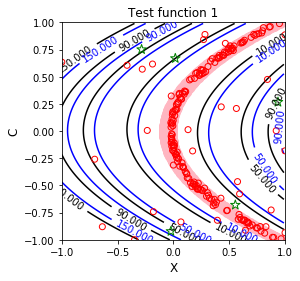

In [24]:
plt.figure(figsize=(4,4))
plt.xlim([-1,1])
plt.ylim([-1,1])

plt.title('Test function 1', fontsize = 12)
plt.xlabel('X', fontsize = 12)
plt.ylabel('C', fontsize = 12)

cs1 = plt.contour(x, y, f1, levels = [10, 50, 90, 150], colors = 'black')
plt.clabel(cs1, cs1.levels, inline = 1, colors = 'black', fontsize=10 )
cs2 = plt.contour(x, y, f2, levels = [10, 50, 90, 150], colors = 'blue')
plt.clabel(cs2, cs2.levels, inline = 1, colors = 'blue', fontsize=10 )



plt.scatter(opt_x, opt_y, color = 'lightpink', alpha = 0.4, zorder=1)
plt.scatter(X[:5,0], X[:5,1], facecolors='none', edgecolors='green', zorder=2, marker='*', s= 100)
plt.scatter(X[5:,0], X[5:,1], facecolors='none', edgecolors='red', zorder=2)
plt.savefig('test_fun1_HPI.png', bbox_inches='tight')
plt.show()

In [12]:
init_sample = 5
c_init = np.random.uniform(-1, 1, init_sample)[:,None]
X = np.zeros((init_sample, bounds.shape[0]))
for i, actions in enumerate(np.random.uniform(bounds[:, 0], bounds[:, 1], (init_sample, bounds.shape[0]))):
    X[i,:] = actions
X = np.hstack((X, c_init))
Y = multi_func(X)

num_output = Y.shape[1]
n_params = bounds.shape[0] + 1

num_iter = 200
c_context = np.random.uniform(-1, 1, size=(num_iter, 1))

for i in range(num_iter):
    pareto = Pareto(np.empty((0, num_output)))
    reference = np.ones((1, num_output))
    
    gp_models = [GPy.models.GPRegression(X.copy(), Y[:,[i]].copy(), kernel= GPy.kern.Matern52(input_dim=n_params, ARD=True)) for i in range(Y.shape[1])]
    for model in gp_models:
        model.optimize()
        
    context_X = np.hstack((X[:,:-1], np.ones((len(X), 1)) * c_context[i]))
    preds =  [m.predict(context_X) for m in gp_models]
    context_Y, var = (np.concatenate(moment, 1) for moment in zip(*preds))
    pareto.update(context_Y)
    
    pf = pareto.front
    f = np.max(pf, axis=0, keepdims=True) - np.min(pf, axis=0, keepdims=True)
    reference = np.max(pf, axis=0, keepdims=True) + 2 * f / pf.shape[0]
    
    next_point = np.atleast_2d(sample_next_point(hypervolume_poi, gp_models, bounds, pareto, reference, c_context[i]))
    next_point = np.hstack((next_point, np.ones((1,1)) * c_context[i]))
    
    X = np.append(X, next_point, axis = 0)
    function_value = multi_func(np.atleast_2d(next_point))
    Y = np.append(Y, function_value, axis = 0)

 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:244: RuntimeWarning:invalid value encountered in true_divide
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply
 /home/cwj/venv/local/lib/python3.5/site-packages/GPy/kern/src/stationary.py:554: RuntimeWarning:invalid value encountered in subtract
 /home/cwj/venv/local/lib/python3.5/site-packages/paramz/transformations.py:108: RuntimeWarning:invalid value encountered in greater
 /home/cwj/venv/local/lib/python3.5/site-packages/paramz/transformations.py:113: RuntimeWarning:invalid value encountered in greater


KeyboardInterrupt: 

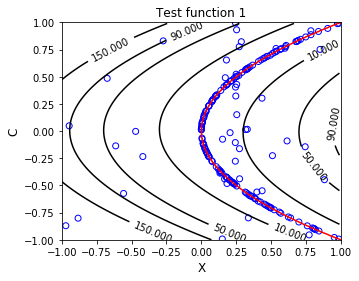

In [13]:
plt.figure(figsize=(5,4))
plt.xlim([-1,1])
plt.ylim([-1,1])

plt.title('Test function 1', fontsize = 12)
plt.xlabel('X', fontsize = 12)
plt.ylabel('C', fontsize = 12)

cs1 = plt.contour(x, y, f1, levels = [10, 50, 90, 150], colors = 'black')
plt.clabel(cs1, cs1.levels, inline = 1, colors = 'black', fontsize=10 )
# cs2 = plt.contour(x, y, f2, levels = [], colors = 'blue')
# plt.clabel(cs2, cs2.levels, inline = 1, colors = 'blue', fontsize=10 )

plt.scatter(X[:,0], X[:,1], facecolors='none', edgecolors='blue')

plt.plot(opt_x, opt_y, color = 'red')
plt.show()